In [1]:
import diffrax
import equinox
import jax
import optax
import scipy.stats

jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
import numpy as np
from matplotlib.figure import Figure
from tqdm.notebook import trange

%matplotlib inline

# Simulate stochastic Lorenz system

In [4]:
@jax.jit
def F_true(x, key, σ=2, T=0.05, dt=1e-2):
    # Lorenz parameters
    sigma = 10.0
    rho = 28.0
    beta = 8 / 3

    # Drift function f(t, y)
    def drift(t, y, _args):
        x, y_, z = y
        dx = sigma * (y_ - x)
        dy = x * (rho - z) - y_
        dz = x * y_ - beta * z
        return jnp.array([dx, dy, dz])

    # Diffusion function g(t, y)
    def diffusion(t, y, _args):
        return jnp.eye(3) * σ

    # SDE solver
    solver = diffrax.ShARK()

    # Solve
    bm = diffrax.VirtualBrownianTree(
        t0=0, t1=T, tol=1e-3, shape=(3,), key=key, levy_area=diffrax.SpaceTimeLevyArea
    )
    # Set up the SDE
    sde = diffrax.MultiTerm(diffrax.ODETerm(drift), diffrax.ControlTerm(diffusion, bm))
    # Solve the SDE
    sol = diffrax.diffeqsolve(
        sde,
        solver=solver,
        t0=0,
        t1=T,
        dt0=dt,
        y0=x,
        # saveat=diffrax.SaveAt(ts=ts),
        max_steps=10000,
    )
    return sol.ys

In [5]:
N = 10000
keys = jax.random.split(jax.random.PRNGKey(3), N)

In [7]:
x = np.zeros((N, 3))
x[0] = [-8.0, 7.0, 27.0]
for i in trange(1, N):
    x[i, :] = F_true(x[i - 1, :], keys[i - 1], σ=2.0, T=0.2, dt=1e-2)

  0%|          | 0/9999 [00:00<?, ?it/s]

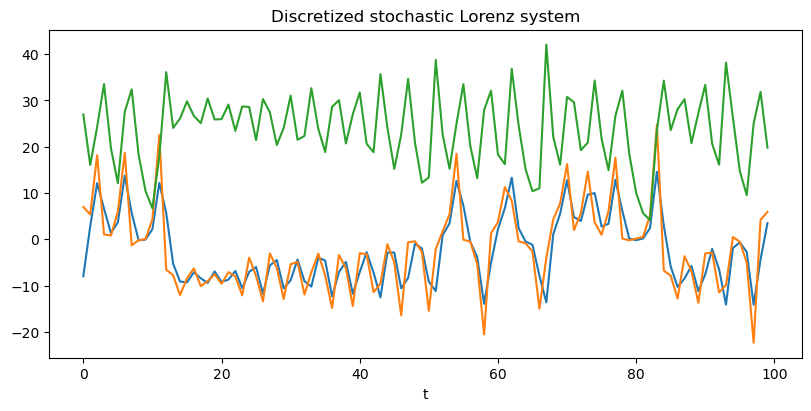

In [8]:
fig = Figure(figsize=(8, 4), dpi=100, constrained_layout=1)
ax = fig.gca()
ax.plot(x[:100,])
ax.set_title("Discretized stochastic Lorenz system")
ax.set_xlabel("t")
fig

# Learn a deep neural approximation to F

In [9]:
import os
import sys

import equinox

lib_path = os.path.join(os.path.curdir, "src")
sys.path.insert(0, lib_path)
import importlib

import probit_network
import random_matrix
import unscented

importlib.reload(unscented)
importlib.reload(random_matrix)
importlib.reload(probit_network)
from probit_network import ProbitLinear, ProbitLinearNetwork
from random_matrix import RandomGaussian, RandomOrthogonalProjection, ZeroMatrix

Network architecure with two hidden layers of 100 neurons each

In [10]:
n_x = 3
n_hidden = 100
network = ProbitLinearNetwork(
    ProbitLinear.create_probit(
        in_size=n_x,
        out_size=n_hidden,
        key=jax.random.PRNGKey(1),
        A=RandomOrthogonalProjection(),
        b=RandomOrthogonalProjection(),
    ),
    ProbitLinear.create_residual(
        in_size=n_hidden,
        out_size=n_hidden,
        key=jax.random.PRNGKey(2),
        A=RandomOrthogonalProjection(),
        b=RandomOrthogonalProjection(),
    ),
    ProbitLinear.create_linear(
        in_size=n_hidden,
        out_size=n_x,
        C=RandomOrthogonalProjection(),
        d=RandomOrthogonalProjection(),
    ),
)

Least-squares loss

In [11]:
def loss(model, x_time_series):
    pred_x = jax.vmap(model)(x_time_series[:-1])
    actual_x = x_time_series[1:]
    return jnp.mean((pred_x - actual_x) ** 2)


loss_value_and_grad = equinox.filter_value_and_grad(loss)

AdamW optimizer with lightly hand-tuned training hyperparameters

In [12]:
opt = optax.adamw(learning_rate=1e-3)

opt_state = opt.init(network)

@equinox.filter_jit
def step(model, x, opt_state):
    loss, grads = loss_value_and_grad(model, x)
    updates, opt_state = opt.update(grads, opt_state, params=model)
    model = equinox.apply_updates(model, updates)
    return loss, model, opt_state

In [13]:
loss_history = []

In [14]:
for i in trange(10000):
    loss, network, opt_state = step(network, x, opt_state)
    loss_history.append(loss)
    if i % 100 == 0:
        loss = loss.item()
        print(i, f"rmse={loss**0.5}")

  0%|          | 0/10000 [00:00<?, ?it/s]

0 rmse=15.210289244695428
100 rmse=6.371244135087314
200 rmse=5.453932820482455
300 rmse=4.833150677450176
400 rmse=4.0659984210659665
500 rmse=3.3250556869056624
600 rmse=2.637096340300631
700 rmse=2.192716803143251
800 rmse=1.9249827626899287
900 rmse=1.739035092787164
1000 rmse=1.6019212245452394
1100 rmse=1.4969618056882108
1200 rmse=1.4146129715283156
1300 rmse=1.3486196294402
1400 rmse=1.2949934052419196
1500 rmse=1.2518598334710536
1600 rmse=1.2172128226694165
1700 rmse=1.1889738407250403
1800 rmse=1.1654638752059896
1900 rmse=1.1469939735880745
2000 rmse=1.1291794042699066
2100 rmse=1.115159947355764
2200 rmse=1.1033208812309718
2300 rmse=1.0931348625442556
2400 rmse=1.0842924853521831
2500 rmse=1.0766207302988806
2600 rmse=1.070006481910761
2700 rmse=1.0642332182628387
2800 rmse=1.0591169582457278
2900 rmse=1.054623418407518
3000 rmse=1.0505822965049851
3100 rmse=1.047289352214078
3200 rmse=1.043731799880657
3300 rmse=1.0407738738769807
3400 rmse=1.038138858816975
3500 rmse=1.

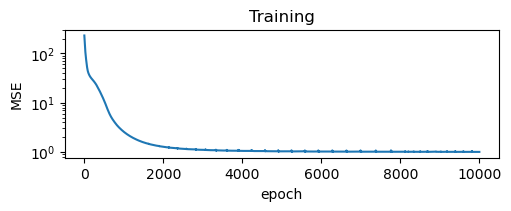

In [15]:
fig = Figure(figsize=(5, 2), constrained_layout=1)
ax = fig.gca()
ax.plot(loss_history)
ax.set_title("Training")
ax.set_ylabel("MSE")
ax.set_xlabel("epoch")
ax.set_yscale("log")
fig

Estimate process covariance using prediction residuals

In [16]:
residual = jax.vmap(network)(x[:-1]) - x[1:]
Q = jax.vmap(jnp.outer)(residual, residual).mean(axis=0)
print("Q eigenvalues", np.linalg.eigvalsh(Q))

Q eigenvalues [0.20695227 1.10486212 1.70307922]


Predict a sample trajectory

In [17]:
x_pred = np.zeros((N, 3))
x_pred[0] = x[0]
for i in trange(1, N):
    x_pred[i, :] = network(x_pred[i - 1, :])

  0%|          | 0/9999 [00:00<?, ?it/s]

Preview the tail of the trajectory (the end is more sensitive to degeneracy than the beginning)

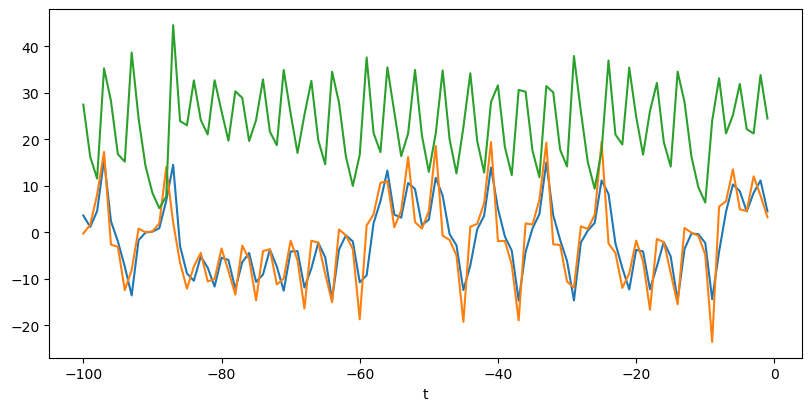

In [18]:
fig = Figure(figsize=(8, 4), dpi=100, constrained_layout=1)
ax = fig.gca()
ax.plot(np.arange(-100, 0), x_pred[-100:])
ax.set_xlabel("t")
fig

# UQ: propagate $\mathcal N(x_0, 10Q)$ through $\hat F$

In [19]:
μ_in = x[0]
Σ_in = 10 * Q

In [28]:
input_samples = scipy.stats.qmc.MultivariateNormalQMC(mean=μ_in, cov=Σ_in, rng=10).random(2**20)
output_samples = jax.vmap(network)(input_samples)

In [29]:
μ_unscented, Σ_unscented = network.propagate_mean_cov(μ_in, Σ_in, method="unscented")
μ_linear, Σ_linear = network.propagate_mean_cov(μ_in, Σ_in, method="linear")
μ_analytic, Σ_analytic = network.propagate_mean_cov(μ_in, Σ_in, method="analytic")

In [30]:
μ_monte_carlo = np.mean(output_samples, axis=0)
Σ_monte_carlo = np.cov(output_samples, rowvar=False, ddof=1)

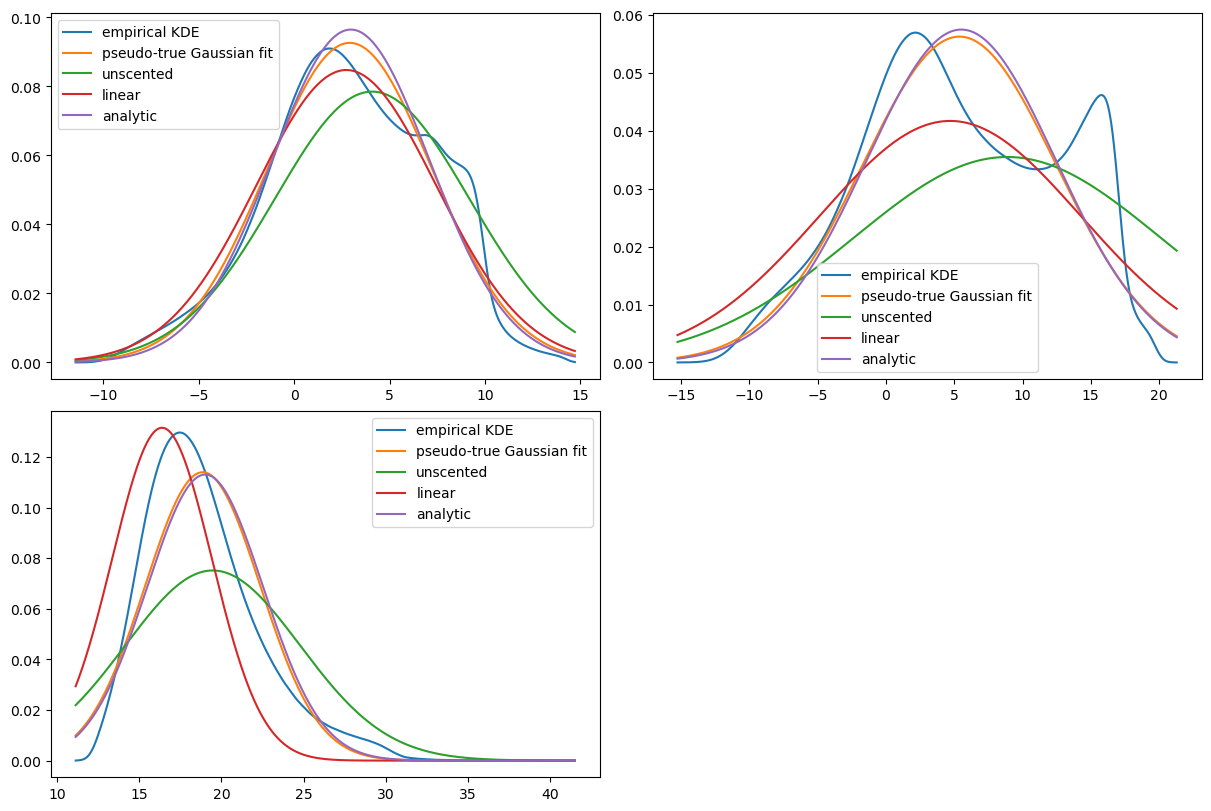

In [31]:
fig = Figure(figsize=(12, 8), dpi=100, constrained_layout=1)
for i in range(3):
    ax = fig.add_subplot(2, 2, i + 1)
    grid = np.linspace(np.min(output_samples[:, i]), np.max(output_samples[:, i]), 2000)
    ax.plot(
        grid,
        scipy.stats.gaussian_kde(output_samples[:, i].reshape(-1))(grid),
        label="empirical KDE",
    )
    for label, μ, Σ, linestyle in (
        ("pseudo-true Gaussian fit", μ_monte_carlo, Σ_monte_carlo, "-"),
        ("unscented", μ_unscented, Σ_unscented, "-"),
        ("linear", μ_linear, Σ_linear, "-"),
        ("analytic", μ_analytic, Σ_analytic, "-"),
    ):
        ax.plot(
            grid,
            scipy.stats.norm.pdf(grid, loc=μ[i], scale=Σ[i, i] ** 0.5),
            label=label,
            linestyle=linestyle,
        )
    ax.legend()

fig